In [1]:
import torch
import time
import torchviz

from mesh_dataset import MeshDataset
from torch.utils.data import DataLoader
from gnn_simplification_model import GNNSimplificationMesh
from loss.loss import total_loss
from tqdm import tqdm

Starting epoch 1


Iterate data:   0%|          | 0/1 [00:00<?, ?it/s]

init input :  0.009797811508178711


e:\shared\projects\Mesh-simplification-GNN\model\mesh_dataset.py:49: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  adjacency_matrix_csr = torch.sparse_csr_tensor(


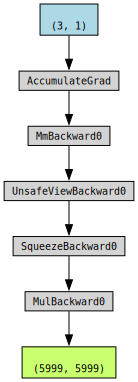

RuntimeError: torch.empty: Only batched sparse compressed (non-block) tensors are supported, but got size [5999]

In [2]:
torch.manual_seed(42)

def train():
    number_neigh_tri = 20

    # if len(graph._node)<20:
    #     raise Exception("Input mesh does not have enough vertices. (More than 20 is needed)")

    torch_dataset = MeshDataset("../3d_models/stl/")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    gnn_model = GNNSimplificationMesh(number_neigh_tri).to(device)
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=1e-5, weight_decay=0.99)


    for epoch in range(0, 1): 
        print(f'Starting epoch {epoch+1}')
        
        current_loss = 0.0
        start = time.time()
        for i, (graph_nodes, graph_adjacency_matrix, triangles) in tqdm(enumerate(torch_dataset), total=len(torch_dataset), desc='Iterate data', leave=False):
            
            graph_nodes, graph_adjacency_matrix = graph_nodes.to(device), graph_adjacency_matrix.to(device)
            optimizer.zero_grad()
            end = time.time()
            print('init input : ', end - start)
            selected_triangles = gnn_model(200, 
                                           graph_nodes, 
                                           graph_adjacency_matrix)
            
            start = time.time()
            loss = total_loss(gnn_model.score_original_points, 
                              graph_nodes, 
                              gnn_model.generated_graph_nodes, 
                              gnn_model.selected_triangles_probabilities, 
                              selected_triangles, 
                              gnn_model.original_barycenters)
            end = time.time()
            print('loss : ', end - start)
            
            current_loss += loss.item()
            if i % 500 == 499:
                print('Loss after mini-batch %5d: %.3f' %
                    (i + 1, current_loss / 500))
                current_loss = 0.0
            
            start = time.time()
    
    # display(torchviz.make_dot(loss))
    start = time.time()
    loss.backward()        
    end = time.time()
    print('backward : ', end - start)
    optimizer.step()            
    print('Training process has finished.')

train()